# Fishers linear discriminant - percepton learning

See: https://scikit-learn.org/stable/modules/lda_qda.html

and https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html

Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import numpy as np
from ROOT import *
from array import array

# For random number generation

from scipy.stats import norm
from scipy.stats import expon

# For plot
from IPython.display import Image

Welcome to JupyROOT 6.24/04


### (1) ROOT settings

In [2]:
# Set ROOT graphics options

gROOT.SetStyle("Plain")

# Default canvas  size

gStyle.SetCanvasDefW(600)
gStyle.SetCanvasDefH(400)
 
# set the margins
  
gStyle.SetPadBottomMargin(0.18)
gStyle.SetPadTopMargin(0.08)
gStyle.SetPadRightMargin(0.08)
gStyle.SetPadLeftMargin(0.17)

# set the number of divisions to show

gStyle.SetNdivisions(510, "xy")

# show grid

gStyle.SetPadGridX(1)
gStyle.SetPadGridY(1)

# border ploted only around statistics

gStyle.SetPadBorderMode(0)
gStyle.SetFrameBorderMode(0)
gStyle.SetLegendBorderSize(0)
gStyle.SetTitleBorderSize(0)
gStyle.SetStatBorderSize(1)

# Text sizes

gStyle.SetTextSize(0.05)
gStyle.SetTitleSize(0.06,"xyz")
gStyle.SetLabelSize(0.05,"xyz")

gStyle.SetLabelOffset(0.015,"xyz")
gStyle.SetTitleOffset(1.2,"yz")
gStyle.SetTitleOffset(1.0,"x")

# Font settings

font = 42
gStyle.SetTitleFont(font)
gStyle.SetTitleFontSize(0.05)
gStyle.SetStatFont(font)
gStyle.SetStatFontSize(0.06)
gStyle.SetTextFont(font)
gStyle.SetLabelFont(font,"xyz")
gStyle.SetTitleFont(font,"xyz")
gStyle.SetLegendFont(font)

# Line settings

gStyle.SetHistLineWidth(2)
gStyle.SetFrameLineWidth(2)
gStyle.SetFuncWidth(2)
gStyle.SetHistLineColor(kBlue)
gStyle.SetFuncColor(kRed)

# Log scale
gStyle.SetOptLogy(0)

# Histogram title
gStyle.SetOptTitle(1)  

# Histogram statistics
gStyle.SetOptStat(1100)

# Fit results
gStyle.SetOptFit(0) 

### (2) Define generation procedure for normal and exponential distribution

In [3]:
# Normal distribution with correlation

def mynorm(Nmc,pos,sig,corr=0.0):

    data = np.empty(shape=(Nmc,2))
    
    phi = 0.5*asin(corr)

    g = np.random.normal(size=(2,Nmc))

    data[:,0] = pos[0] + sig[0]*(g[0]*cos(phi) + g[1]*sin(phi))
    data[:,1] = pos[1] + sig[1]*(g[0]*sin(phi) + g[1]*cos(phi))
    
    return data

# Exponential distribution with correlation

def myexpo(Nmc,pos,sig,corr=0.0):

    data = np.empty(shape=(Nmc,2))
    
    phi = 0.5*asin(corr)

    g = np.random.normal(size=(2,Nmc))

    r1_tab = g[0]*cos(phi) + g[1]*sin(phi)
    r2_tab = g[0]*sin(phi) + g[1]*cos(phi)

# Convert correlated gaussian variables r1 & r2 
# to correlated exponential variables, based on survival function

    s1_tab = norm.sf(r1_tab)
    s2_tab = norm.sf(r2_tab)
    
    data[:,0] = pos[0] + sig[0]*expon.isf(s1_tab)
    data[:,1] = pos[1] + sig[1]*expon.isf(s2_tab)
    
    return data

### (3) Generating training and test data

In [53]:
# Sample size

Ntrain = 1000
Ntest = 1000

# Two hypothesis:

# H1: Exponential background

h1 = np.array([-1.,-1.])
sig1 = np.array([2.0,2.0])
corr1 = 0.0

# H2: Normal distribution

h2 = np.array([1.,1.])
sig2 = np.array([0.3,0.3])
corr2 = 0.0

# Fraction of first hypothesis

fh1 = 0.3

# Generate train sample 
# ---------------------

h1train = myexpo(Ntrain,h1,sig1,corr1)
h2train = mynorm(Ntrain,h2,sig2,corr2)

# Uniform distributed numbers

rtrain = np.random.uniform(size=Ntrain)

# Mix of two hypothesis

y_train = rtrain > fh1

y2_train = np.resize(np.repeat(y_train,2),(Ntrain,2))

X_train = y2_train * h1train + (1 - y2_train)*h2train

print("Train data defined, size: ",y_train.size)

# Generate test sample 
# --------------------

h1test = myexpo(Ntest,h1,sig1,corr1)
h2test = mynorm(Ntest,h2,sig2,corr2)

# Uniform distributed numbers

rtest = np.random.uniform(size=Ntest)

# Mix of two hypothesis

y_test = rtest > fh1

y2_test = np.resize(np.repeat(y_test,2),(Ntest,2))

X_test = y2_test * h1test + (1 - y2_test)*h2test

print("Test data defined, size: ",y_test.size)

# Rescale category from {0,1} to {-1,1}

y_train = 2*y_train - 1
y_test = 2*y_test - 1

Train data defined, size:  1000
Test data defined, size:  1000


### (4) Iterative approach

In [93]:
# Number of nodes in hidden layer

Nh = 20

# Start from random weights and offset

# Output node weights

w1vec = np.random.uniform(size=Nh)-0.5
w1cut = np.random.uniform()-0.5

# Wights for two hiden nodes

w2vec = np.random.uniform(size=(Nh,2))-0.5
w2cut = np.random.uniform(size=Nh)-0.5


In [94]:
# Initial prediction

hpred = np.tanh(X_train @ np.transpose(w2vec) - w2cut)
ypred  = np.tanh( (hpred @ w1vec) - w1cut) 

dy = ypred - y_train
dist = np.sum(dy*dy)
nok = np.sum(ypred*y_train > 0)

print("Initial distance: ",sqrt(dist),", ",nok," events properly classified")


Initial distance:  34.832091675093125 ,  341  events properly classified


In [95]:
# Iteration starting step

eta = 1.

it = 0
dmin = dist
  
while True :

    it+=1
    
    # Adjust output layer weights
    
    dy1 = (1+ypred)*(1-ypred)*dy
    dw1 = dy1 @ hpred

    w1cut += eta/Ntrain * np.sum(dy1)
    w1vec -= eta/Ntrain * dw1
    
    # Adjusting hidden layers weights
    
    dh2 = (1+hpred)*(1-hpred)*np.outer(dy1,w1vec)
    dw2 = np.transpose(dh2) @ X_train
    
    w2cut += eta/Ntrain * np.sum(dh2,axis=0) 
    w2vec -= eta/Ntrain * dw2
    
    hpred = np.tanh(X_train @ np.transpose(w2vec) - w2cut)
    ypred  = np.tanh( (hpred @ w1vec) - w1cut) 

    nok = np.sum(ypred*y_train > 0)

    dy = ypred - y_train
    dist = np.sum(dy*dy)

#    if dist < dmin :

#    w1cut = c1new
#    w1vec = w1new
#    w2cut = c2new
#    w2vec = w2new
    
    eta *= 0.99
    
#    eta *= 2.0
#    dmin = dist
        
# Debug printout
#        print(it,eta,w1new,w2new,c1new,c2new,nok,dist)
  
#    else:
#        eta /= 2.
        
#    if eta < 0.0000001 : break
    
    if nok == Ntrain : break
    
    if it == 10000 : break

  
# Normalized direction vector

print(it," iterations, final distance: ",sqrt(dist),", ",nok," events properly classified")

# Check test sample

hpred = np.tanh(X_test @ np.transpose(w2vec) - w2cut)
ypred  = np.tanh( (hpred @ w1vec) - w1cut) 
    
nok = np.sum(ypred*y_test > 0)

print(nok," events properly classified for test sample")


10000  iterations, final distance:  15.387391889772909 ,  919  events properly classified
941  events properly classified for test sample


In [96]:
ai = -w2vec[:,0]/w2vec[:,1]
bi = w2cut/w2vec[:,1]

print("Discriminant line: y = ",ai," * x  +  ",bi)


Discriminant line: y =  [ -1.08026269   1.93952061  -0.83710656  -0.83228165  -0.91312122
  -1.01376336   1.69104527  -0.9881397   -0.84707791   0.89167366
   0.19675093  -1.4210408   -0.98786057 -20.47456898  -1.84233032
  -1.32203198  -1.09593577  -0.80159488  -0.69293857   0.25695032]  * x  +   [ 2.30193297  0.74175264 -1.48915772 -4.66593039 -3.88910728 -0.16364724
  0.8478159  -3.70451322 -2.06321482 -0.64718571  0.69292213 -0.06524639
  0.57272365  6.07719806 -0.19027504 -2.08321941  0.19909524 -4.8342654
 -0.02687043 -0.30702032]


### (5) Plot results

In [97]:
# Square plot

gStyle.SetCanvasDefW(900)
gStyle.SetCanvasDefH(600)

# Create plot canvas

cexp = TCanvas('cexp')
   
# Create data graph - train data

tgr = TGraph(y_train.size,array('d',X_train[:,0]),array('d',X_train[:,1]))

# Set graph options

tgr.SetNameTitle("tgr","Linear discriminant - percepton learning")
tgr.SetMarkerStyle(20)
tgr.SetMarkerSize(0.7)
tgr.SetMarkerColor(4)

tgr.GetXaxis().SetTitle("x_{1}")
tgr.GetYaxis().SetTitle("x_{2}")

# One of the sets

nt1 = np.sum(y_train==1)

Xt1 = np.zeros(shape=(nt1,2))

it1 = 0
for ip in range(y_train.size):
    if y_train[ip]==1 :
        Xt1[it1]=X_train[ip]
        it1+=1
             
tgr1 = TGraph(int(nt1),array('d',Xt1[:,0]),array('d',Xt1[:,1]))

# Set graph options

tgr1.SetNameTitle("tgr1","Train data")
tgr1.SetMarkerStyle(20)
tgr1.SetMarkerSize(0.7)
tgr1.SetMarkerColor(3)
    
# Create data graph - test data

rgr = TGraph(y_test.size,array('d',X_test[:,0]),array('d',X_test[:,1]))

# Set graph options

rgr.SetNameTitle("rgr","Linear discriminant - percepton learning")
rgr.SetMarkerStyle(20)
rgr.SetMarkerSize(0.7)
rgr.SetMarkerColor(4)

rgr.GetXaxis().SetTitle("x_{1}")
rgr.GetYaxis().SetTitle("x_{2}")

# One of the sets

n1 = np.sum(y_test==1)

X1 = np.zeros(shape=(n1,2))

ip1 = 0
for ip in range(y_test.size):
    if y_test[ip]==1 :
        X1[ip1]=X_test[ip]
        ip1+=1
        


        
rgr1 = TGraph(int(n1),array('d',X1[:,0]),array('d',X1[:,1]))

# Set graph options

rgr1.SetNameTitle("rgr1","Test data")
rgr1.SetMarkerStyle(20)
rgr1.SetMarkerSize(0.7)
rgr1.SetMarkerColor(3)
    
# Line found by iteration

ldi = TF1("ld1","pol1",-10.,10.,2)
ldi.SetLineStyle(2)
ldi.SetLineColor(2)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: cexp


In [98]:
# Decision histogram (as background)

Xmin = -0.999
Xmax = 4.999
Nbin = 240
dX = (Xmax-Xmin)/Nbin

nbhist = TH2D("nbhist","Percepton learning",Nbin,Xmin,Xmax,Nbin,Xmin,Xmax)

for ix in range(Nbin):
    for iy in range(Nbin):
        x1 = Xmin+(ix+0.5)*dX
        x2 = Xmin+(iy+0.5)*dX
        X = np.array([x1,x2])
        hpred = np.tanh(X @ np.transpose(w2vec) - w2cut)
        ypred  = ( (hpred @ w1vec) - w1cut) > 0.
    
        
        nbhist.Fill(x1,x2,ypred)

# Do not show histogram statistics

nbhist.SetStats(0)
nbhist.SetMaximum(1.0)
nbhist.SetMinimum(0.0)
nbhist.GetXaxis().SetTitle("x_{1}")
nbhist.GetYaxis().SetTitle("x_{2}")


Warning in <TROOT::Append>: Replacing existing TH1: nbhist (Potential memory leak).


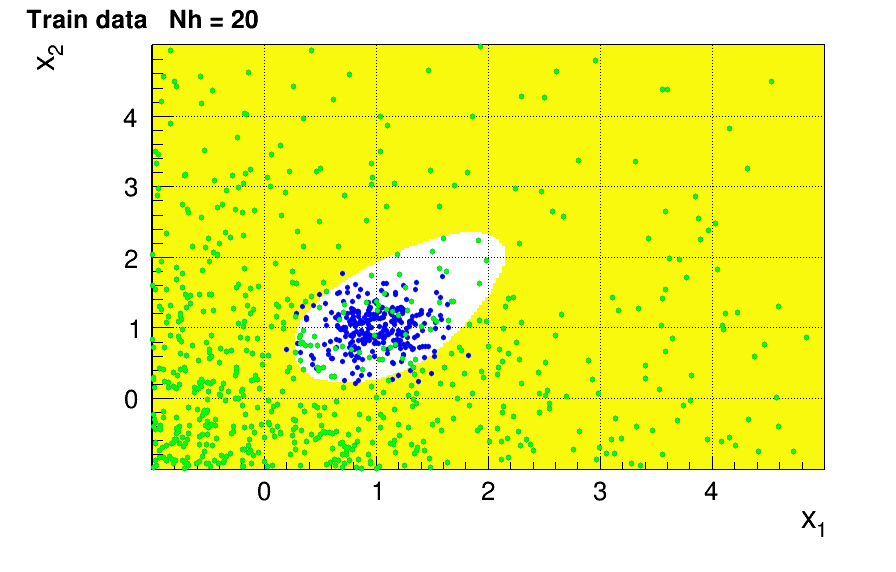

Info in <TCanvas::Print>: png file 12_Fisher4_0.0_20_train.png has been created


In [99]:
# Plot 

nbhist.SetTitle("Train data   Nh = "+str(Nh))
nbhist.Draw("COL")

tgr.Draw('P')
tgr1.Draw('P')

if Nh < 5:
    for ih in range(Nh):
        ldi.SetParameters(bi[ih],ai[ih])
        ldi.DrawCopy('same')

cexp.Update()

fname = '12_Fisher4_'+str(corr2)+'_'+str(Nh)+'_train.png'
    
cexp.Print(fname)

Image(filename=fname)

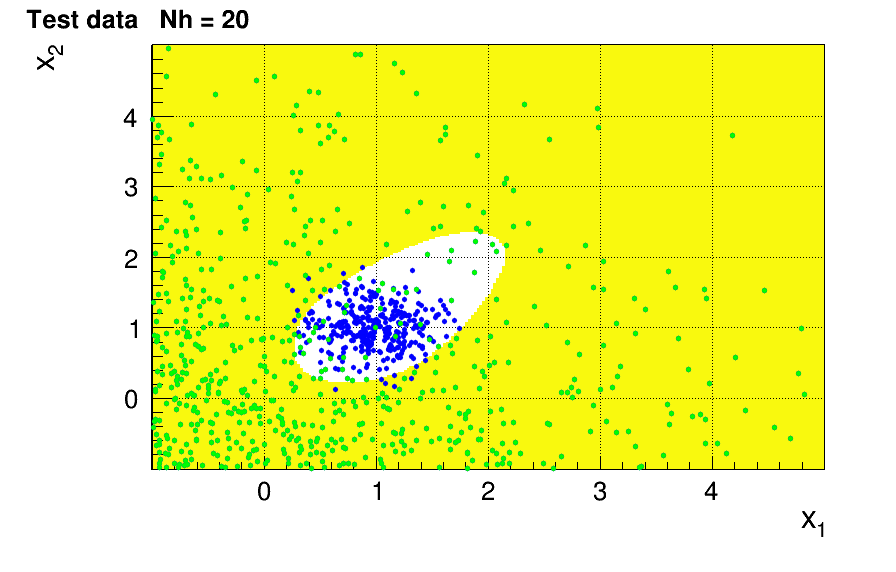

Info in <TCanvas::Print>: png file 12_Fisher4_0.0_20_test.png has been created


In [100]:
# Plot 

nbhist.SetTitle("Test data   Nh = "+str(Nh))
nbhist.Draw("COL")

rgr.Draw('P')
rgr1.Draw('P')

if Nh < 5:
    for ih in range(Nh):
        ldi.SetParameters(bi[ih],ai[ih])
        ldi.DrawCopy('same')

cexp.Update()

fname = '12_Fisher4_'+str(corr2)+'_'+str(Nh)+'_test.png'
    
cexp.Print(fname)

Image(filename=fname)